# Information Retrieval Assignment 1

Author: Aeirya Mohammadi

aeirya@gmail.com

## Preparation

In [3]:
# setup colab drive
from google.colab import drive
drive.mount('/content/drive/')

dir = '/content/drive/MyDrive/Assignment/InformationRetrieval/hw1/dataset/'

Mounted at /content/drive/


In [4]:
# let's import needed libraries
import spacy
import pandas as pd
import numpy as np
from numpy.linalg import norm

In [5]:
# read csv files
def read_file(filename):
  return pd.read_csv(dir + filename)

docs = read_file('hw1_docs.csv')
queries = read_file('hw1_queries.csv')
qrels = read_file('hw1_qrels.csv')

In [6]:
# text preprocessing
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    # dropping stop words and punctuations
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

In [7]:
docs['processed_doc'] = docs['document'].apply(preprocess)

In [8]:
queries['processed_query'] = queries['query'].apply(preprocess)

### Getting Familiar with the data

In [9]:
qrels.head()

,query_id,doc_id
0,1,005b2j4b
1,1,0chuwvg6
2,1,0t2a5500
3,1,0y34yxlb
4,1,105q161g


In [10]:
docs.head()

,doc_id,document,processed_doc
0,2p7qrgx0,"Since 2007, many cases of fever, thrombocytope...",2007 case fever thrombocytopenia leukopenia sy...
1,25dcnext,BACKGROUND: Respiratory viral (RV) outbreaks i...,BACKGROUND respiratory viral RV outbreak rehab...
2,2jq626ye,A novel coronavirus (2019-nCoV) originating in...,novel coronavirus 2019 nCoV originate Wuhan Ch...
3,270msv5l,• Several studies suggested Baricitinib as a p...,study suggest Baricitinib potential drug manag...
4,14x4uqq7,Evidence from the 2003 SARS epidemic and 2009 ...,evidence 2003 SARS epidemic 2009 H1N1 pandemic...


In [11]:
queries.head()

,query_id,query,processed_query
0,1,what is the origin of COVID-19,origin COVID-19
1,2,how does the coronavirus respond to changes in...,coronavirus respond change weather
2,3,will SARS-CoV2 infected people develop immunit...,SARS CoV2 infect people develop immunity cross...
3,4,what causes death from Covid-19?,cause death Covid-19
4,5,what drugs have been active against SARS-CoV o...,drug active SARS CoV SARS CoV-2 animal study


In [12]:
series = pd.Series(qrels['query_id'])
print(series.searchsorted(2))
print(series.searchsorted(3))
# it seems the qrels data provides 15 best documents for each query

15
30


In [13]:
# checking data and trying to see if qrels is sorted by relevance

print("query 10: " + queries['query'][9])

best_relevant = qrels['doc_id'][9*15]
worst_relevant = qrels['doc_id'][9*15+14]
table = docs[docs['doc_id'].isin([best_relevant, worst_relevant])]

print('more relevant:', table.iloc[0]['document'])
print('less relevant:', table.iloc[1]['document'])

# and the answer is probably yes!

query 10: has social distancing had an impact on slowing the spread of COVID-19?
more relevant: Objective: In absence of any vaccine, the Corona Virus Disease 2019 (COVID-19) pandemic is being contained through a non-pharmaceutical measure termed Social Distancing (SD). However, whether SD alone is enough to flatten the epidemic curve is debatable. Using a Stochastic Computational Simulation Model, we investigated the impact of increasing SD, hospital beds and COVID-19 detection rates in preventing COVID-19 cases and fatalities. Research Design and Methods: The Stochastic Simulation Model was built using the EpiModel package in R. As a proof of concept study, we ran the simulation on Kasaragod, the most affected district in Kerala. We added 3 compartments to the SEIR model to obtain a SEIQHRF (Susceptible-Exposed-Infectious-Quarantined-Hospitalised-Recovered-Fatal) model. Results: Implementing SD only delayed the appearance of peak prevalence of COVID-19 cases. Doubling of hospital bed

#### Gold related documents

In [14]:
doc_id_to_index = {}
for i, doc_id in enumerate(docs['doc_id']):
  doc_id_to_index[doc_id] = i

def doc_index(doc_id):
  return doc_id_to_index[doc_id]

In [15]:
def gold_related_docs(qid):
  '''
  qid: query id
  '''
  related_ids = qrels['doc_id'][qid*15:(qid+1)*15]
  return np.array([doc_index(id) for id in related_ids])

gold_best = np.zeros((len(queries), 15)).astype(int)
for q in range(len(queries)):
  gold_best[q, :] = gold_related_docs(q)

## TF-IDF

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# NOTE: here I prefered using nonbinary vectorizer to get better results
vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,1), max_df=0.8, token_pattern='\w*[a-z]+\w*')

# now lets fetch embed documents and queries

# documents tfidf matrix
D = vectorizer.fit_transform(docs['processed_doc'])

# queries' tfidf matrix
Q = vectorizer.transform(queries['processed_query'])

D.shape
# you could see the vector size is bigger than 1000

(750, 3030)

In [17]:
vocab = vectorizer.get_feature_names_out()
vocab

array(['11th', '15th', '1st', ..., 'zoonotic', 'µm', 'μg'], dtype=object)

In [18]:
# since we're just ranking similarities, the size of a query vector is not needed, then we're not gonna use this function here
def cosine_sim(v1, v2):
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

norm = np.linalg.norm(D.toarray(), ord=2, axis=1)
norm[0:5]
# it also seems the document embedding vectors are already normal so no need to normalize here

array([1., 1., 1., 1., 1.])

In [19]:
# similarity matrix of querries to documents
sim_matrix = Q @ D.T
sim_matrix.shape

(50, 750)

In [20]:
# top 10 for each query
best = np.argpartition(sim_matrix.toarray(), -10, axis=1)[:, -10:]
best.shape

(50, 10)

In [21]:
tfidf_scores = sim_matrix.toarray()

#### Check correctness of results

In [22]:
best[0:3]

array([[396, 748, 609, 435, 637, 389, 742, 557, 668, 425],
       [104, 556, 168, 384, 701, 264, 642, 601,  70, 139],
       [667, 485, 253, 172,  14, 281, 235, 586, 297,  38]])

In [23]:
gold_best[0:3]

array([[502, 736,  20, 255, 748, 199, 597, 609, 490, 425, 742, 396, 512,
        286, 634],
       [531, 602, 285, 264, 221, 717, 139, 702, 150, 495, 261, 642, 576,
        592, 601],
       [586, 579, 136, 510, 126, 514, 485, 172,  75, 239, 693, 134, 699,
        732, 603]])

In [24]:
result = np.ones_like(best)
for q in range(len(queries)):
  wrong_idx = np.setdiff1d(best[q, :], gold_related_docs(q))
  result[q, :] = np.where(np.isin(best[q], wrong_idx), 0, result[q])

tf_idf_result = np.array(result)
result[0:3]

array([[1, 1, 1, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 0, 0]])

In [25]:
sim_matrix[0, best[0]].toarray()
# we can see the best matrix isn't sorted so we'll have do it for evaluation

array([[0.13610416, 0.15588963, 0.13793573, 0.14600265, 0.16434055,
        0.16516415, 0.16807466, 0.24941631, 0.16516415, 0.1894379 ]])

## BIM

In [26]:
# perpare data

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, token_pattern='\w*[a-z]+\w*', min_df=3, max_df=0.8)

D = vectorizer.fit_transform(docs['processed_doc'])
Q = vectorizer.transform(queries['processed_query'])

vocab = vectorizer.get_feature_names_out()
vocab_size = len(vocab)

In [27]:
# df_t: the number of dumments that contain term t
dft = D.sum(axis=0)[0]

N = D.shape[1]
ut = dft/N

iut = 1/ut

We have RSV_d = sum_{t: x_t = q_t = 1} log([p_t/(1-p_t)] * [(1-u_t)/u_t]) = sum log([X] * [iut]) = sum log (r)

Notice that (1-ut)/ut = (N - df)/df ~ N/df = 1/ut = iut

NOTE: since we KNOW that we are going to redo some calculations between queries, I'm going to aggregate the vocab of all queries first to do some optimization and calculate pt/(1-pt) for the needed terms

In [28]:
# the terms that appear in queries
t = Q.sum(axis=0) > 0

In [29]:
def calc_X(p):
  return np.ones((1,vocab_size)) * p/(1-p)

def f(p):
  X = calc_X(p)
  return np.where(t, np.log(np.multiply(X, iut)), 0)[0]

Da = D.toarray()
Qa = Q.toarray()

# BIM_results = {}
BIM_scores = {}

for p in [0.3, 0.5, 0.7]:
  r = f(p)

  scores = np.zeros((Q.shape[0], D.shape[0]))
  # todo: optimize
  for d in range(D.shape[0]):
    for q in range(Q.shape[0]):
      scores[q,d] = r[(Da[d] > 0) & (Qa[q] > 0)].sum()

  # BIM_results[p] = correctness_matrix(top10matrix(scores))
  BIM_scores[p] = scores

In [30]:
# BIM_results[0.5][0:3]

## BM25

In [31]:
vectorizer = CountVectorizer(binary=False, token_pattern='\w*[a-z]+\w*', min_df=3, max_df=0.8)

D = vectorizer.fit_transform(docs['processed_doc'])
Q = vectorizer.transform(queries['processed_query'])

In [32]:
# convert sparse matrices to term existence masks
Qt = Q.toarray() > 0

Da = D.toarray()

Document Score:
∑_{t∈q} log (N/dft) (k1+1)tf / [k1((1-b)+b(Ld/Lave))+tf]

∑log iut A / B

In [33]:
def bm25(D, Q, Da, Qt, k, b):
  # document length
  Ld = D.sum(axis=1)
  # average document length
  Lave = Ld.mean()

  L = Ld/Lave

  nQ = Q.shape[0]
  nD = D.shape[0]
  scores = np.zeros((nQ, nD))

  for q in range(nQ):
    for d in range(nD):

      # mask
      m = Qt[q]

      logiut = np.array(np.log(iut[0,m]).T)[:, 0]

      # term frequencies in the document
      tf = Da[d, m]


      A = (k+1) * tf
      B = tf + k*(1 - b + b * L[d,0])

      scores[q,d] = (logiut * A/B).sum()

  return scores

### Find Top 10
this code was moved here because I needed a function

In [53]:
def top10_unsorted_matrix(score_matrix):
  '''
  score_matrix: Q -> D
  top 10 document for each query
  '''

  return np.argpartition(score_matrix, -10, axis=1)[:, -10:]


def correctness_matrix(best):
  '''
  reports correctness of the 'best' matrix with a matrix of zeros and ones of the same size
  '''

  result = np.ones_like(best)

  # number of queries
  nQ = best.shape[0]

  for q in range(nQ):
    wrong_idx = np.setdiff1d(best[q, :], gold_related_docs(q))
    result[q, :] = np.where(np.isin(best[q], wrong_idx), 0, result[q])

  return np.array(result)


def sorted_best(scores):
  best = top10_unsorted_matrix(scores)

  for i in range(Q.shape[0]):
    sorted_idx = scores[i, best[i]].argsort()[-1::-1]
    best[i,:] = best[i,sorted_idx]

  iscorrect = correctness_matrix(best)

  return best, iscorrect

# top 10 correctness map matrix
def cmap(scores):
  '''
  scores -> top 10 best scores and its correctness matrix
  '''

  _, incorrect = sorted_best(scores)
  return incorrect

#### Hyperparameters
Now lets choose best hyperparameters k and b

In [37]:
K = np.linspace(0.6, 2.4, num=10)
B = np.linspace(0.3, 1.5, num=9)

# use number of correct retrievals as the evaluation metric of score matrix
sc = lambda scores: scores.sum(axis=None)

# to find the best hyperparameters, we only use a subset of our data
D_dev = D[0:150]
Da_dev = Da[0:150]
Q_dev = Q[0:15]
Qt_dev = Qt[0:15]

kb_sc = np.zeros(shape=(K.shape[0], B.shape[0]), dtype=int)
for i,k in enumerate(K):
  for j,b in enumerate(B):
    scores = correctness_matrix(top10_unsorted_matrix(bm25(D_dev, Q_dev, Da_dev, Qt_dev, k, b)))
    kb_sc[i,j] = sc(scores)

kb_sc

array([[25, 25, 25, 25, 24, 25, 24, 24, 24],
       [25, 25, 25, 25, 25, 24, 24, 24, 24],
       [25, 25, 26, 25, 25, 24, 24, 24, 22],
       [25, 26, 26, 25, 25, 25, 24, 23, 22],
       [26, 26, 26, 26, 25, 24, 24, 24, 22],
       [26, 27, 27, 26, 25, 25, 25, 23, 22],
       [26, 26, 27, 26, 25, 25, 24, 23, 22],
       [26, 27, 27, 25, 25, 25, 24, 22, 22],
       [26, 27, 27, 25, 25, 25, 24, 22, 20],
       [25, 27, 26, 25, 25, 25, 24, 23, 20]])

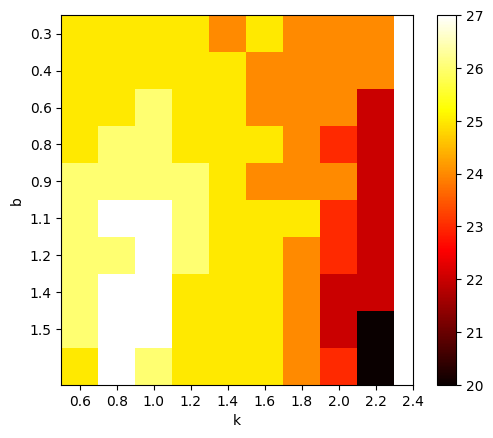

In [38]:
import matplotlib.pyplot as plt

data = kb_sc

plt.imshow(data, cmap='hot', interpolation='nearest')

plt.colorbar()
plt.title('')

plt.xlabel('k')
plt.ylabel('b')

Klabels = ['']

plt.xticks(range(len(K)), [f'{k:.1f}' for k in K])
plt.yticks(range(len(B)), [f'{b:.1f}' for b in B])

# display the heatmap
plt.show()

Here we have plotted corresponding scores different ks and bs

In [39]:
i = np.argmax(kb_sc)
k = K[i % len(B)]
b = B[i // len(B)]
k,b

(0.7999999999999999, 1.05)

### Results

In [40]:
bm25_scores = bm25(D, Q, Da, Qt, k, b)

## Evaluation

### MAP

In [56]:
# this is the previous implementation, which was replaced by a faster one
def _for_average_precision(r):
  '''
  r: correctness matrix row, consisting of ones and zeros
  one stands for correct retrieved document
  '''

  n = r.shape[1]

  # since we only have top 10 documents, i'll suppose the 5 rest documents are irrelevant
  z = np.zeros(15)
  z[:n] = r[0,:]

  r = z
  n = 15

  num = r.cumsum() * r
  denom = np.arange(n) + 1

  # for i in range(n):
  #   print(f'{num[i]} / {denom[i]}')

  return (num / denom).mean()

def _for_mean_average_precision(cm):
  n = cm.shape[0]
  ap = np.zeros(n)
  for i in range(n):
    ap[i] = _for_average_precision(cm[i])

  return ap.mean()

def MAP(cm):
  n, m = cm.shape
  z = np.zeros((n, 15))
  z[:, :m] = cm

  num = z.cumsum(axis=1) * z
  denom = np.repeat([np.arange(15)], n, axis=0) + 1

  return (num / denom).mean(axis=None)

### P@K

In [42]:
def PAt(k, cm):
    return cm[:,:k].mean(axis=1).mean()

### Reciprocal Rank

In [43]:
def MRR(cm):
    return (1 / (cm.argmax(axis=1) + 1)).mean()

### Calculate & Plot

In [54]:
# score matrix for each algorithm
scores_m = {
    'TFIDF': tfidf_scores,
    'BIM 0.3': BIM_scores[0.3],
    'BIM 0.5': BIM_scores[0.5],
    'BIM 0.7': BIM_scores[0.7],
    'BM25': bm25_scores
}

scores_cmap = { key: cmap(val) for key,val in scores_m.items() }

In [58]:
scores = np.zeros((5,4))

for i,m in enumerate(scores_cmap.values()):
  scores[i, 0] = MAP(m)
  scores[i, 1] = PAt(5, m)
  scores[i, 2] = PAt(10, m)
  scores[i, 3] = MRR(m)

scores

array([[0.33616243, 0.696     , 0.576     , 0.91122222],
       [0.22118519, 0.512     , 0.444     , 0.77130159],
       [0.20893175, 0.48      , 0.434     , 0.7309127 ],
       [0.20203175, 0.452     , 0.426     , 0.73119048],
       [0.26654762, 0.592     , 0.508     , 0.80719048]])

Text(0.5, 1.0, 'Scores')

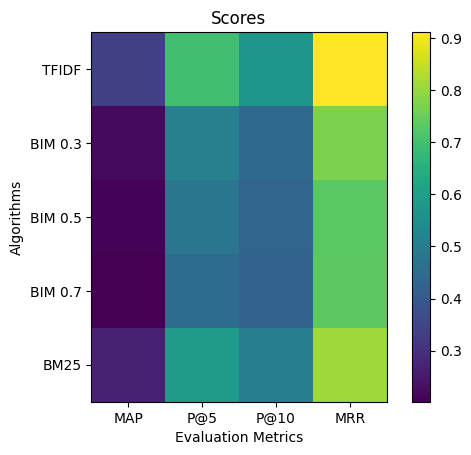

In [70]:
plt.imshow(scores, cmap='viridis')

plt.ylabel('Algorithms')
plt.xlabel('Evaluation Metrics')

plt.colorbar()

plt.xticks(range(4), ['MAP', 'P@5', 'P@10', 'MRR'])
plt.yticks(range(len(scores)), list(scores_cmap.keys()))
plt.title('Scores')